問題設定  
データの分布：平均mu(未知)、分散sigma(既知)の正規分布。平均パラメータの分布を知りたい。  
事前分布：平均0, 分散１の正規分布  
  

正選手問題　　
A vs Bの最近の成績は３勝４敗。ただ、１週間前までは８勝２敗だった。AとBどちらの実力が高いか。
  
波平釣果問題  
波平さんの釣果：0, 1, 0, 0, 2, 0, 1, 0, 0, 1  
0匹の確率は？  

ポアソン分布  
$$f(x|\theta) = \frac{e^{-\theta} \theta^x}{x!}$$

ガンマ分布
$$f(x|\alpha, \lambda) = \frac{\lambda^\alpha}{\Gamma (\alpha)} x^{\alpha - 1} e^{-\alpha x}$$

事前分布を$\alpha=6, \lambda=3$のガンマ分布とする。平均は$\alpha/\lambda=2$、分散は$\alpha/\lambda^2=0.667$となる。
事後分布は$\alpha=6+5=11, \lambda=3+10=13$のガンマ分布となる。このとき、$\theta_{eap}=0.846$となる。

一方で、ポアソン分布の最尤推定量は0.5となる。

主観的はない事前分布の設定は、1. 無情報事前分布、2. 自然共役事前分布が考えられる。2の場合は解析的に事後分布が求まるという長所はある。
  
未知のデータに対する予測分布としては、
1. 条件付き予測分布：パラメータの事後分布からの点推定値を利用
2. 事後予測分布：モデル分布✖️事後分布をパラメータについて積分

がある。
  
MCMCの動機：事後分布を解析的に求めるのは、正規化定数の積分を伴い、難しい。事後分布に従う乱数を発生させ、事後分布の評価を行う。  
マルコフ連鎖：１期前の状態だけによる条件付き確率分布。この条件付き確率を遷移核という。確率分布が変化しなくなったとき、定常分布へ収束したという。  
MCMCではサンプリングしたい事後分布が定常分布となるようなマルコフ連鎖を設計する。
  
詳細釣り合い条件を満たす時、マルコフ連鎖は定常分布に収束する。
  
波平釣果問題で、事後分布を解析的に算出できないと想定して、サンプリングを試みる。事前分布✖️尤度（事後分布に比例）、書籍ではカーネルと呼んでいる。は計算できる。

In [130]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from tqdm import tqdm_notebook
from scipy.stats import norm, poisson, gamma, uniform
sns.set(style="white")

np.random.seed(1)

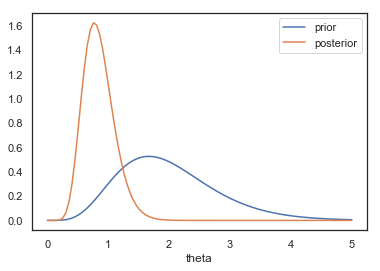

In [10]:
x = np.linspace(0, 5, 100)
plt.plot(x, gamma.pdf(x, a=6, scale=1./3), label="prior")
plt.plot(x, gamma.pdf(x, a=11, scale=1./13), label="posterior")
plt.xlabel("theta")
plt.legend()

In [166]:
gamma(a=11, scale=1./13).mean()

0.8461538461538463

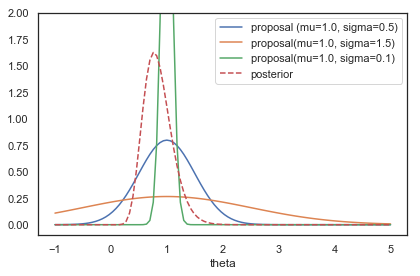

In [64]:
x = np.linspace(-1, 5, 100)
plt.plot(x, norm.pdf(x, loc=1.0, scale=0.5), label="proposal (mu=1.0, sigma=0.5)")
plt.plot(x, norm.pdf(x, loc=1.0, scale=1.5), label="proposal(mu=1.0, sigma=1.5)")
plt.plot(x, norm.pdf(x, loc=1.0, scale=0.1), label="proposal(mu=1.0, sigma=0.1)")
plt.plot(x, gamma.pdf(x, a=11, scale=1./13), linestyle="--", label="posterior")
plt.xlabel("theta")
plt.ylim(-0.1, 2)
plt.legend()
plt.tight_layout()
plt.savefig("proposal_dists.png")

In [65]:
# 独立MH法
lam = 2
data = [0, 0, 0, 0, 0, 0, 1, 1, 1, 2]


def posterior_kernel(lam):
    if lam < 0:
        return 0
    likelihood = poisson.pmf(data, mu=lam).prod()
    prior = gamma.pdf(lam, a=6, scale=1./3)
    return prior * likelihood


def independent_MH(mu_proposal, scale_proposal, ax, theta_init=1.0, n_sample=6000, burn=1000):
    theta_current = theta_init
    posterior = [theta_current]
    count = 0 # count accepted proposals
    
    for i in tqdm_notebook(range(n_sample)):

        proposal_dist = norm(loc=mu_proposal, scale=scale_proposal)
        theta_proposal = proposal_dist.rvs()

        # Lieklihood x prior
        p_current = posterior_kernel(theta_current)
        p_proposal = posterior_kernel(theta_proposal)

        # probability to accept proposal
        p_accept = proposal_dist.pdf(x=theta_current) * p_proposal / \
        (proposal_dist.pdf(x=theta_proposal) * p_current)

        if np.random.rand() < p_accept:
            count += 1
            theta_current = theta_proposal

        posterior.append(theta_current)
    
    g = sns.distplot(posterior[burn:], ax=ax, label="posterior samples")
    g.plot(x, gamma.pdf(x, a=11, scale=1./13), label="theoretical posterior")
    g.legend()
    g.set_title(f"proposal mu: {mu_proposal}, sigma: {scale_proposal}")
    g.set_xlim(0, 2.5)
    print("accept ratio: {:.2%}".format(count / n_sample))

accept ratio: 53.65%


accept ratio: 20.12%


accept ratio: 39.65%


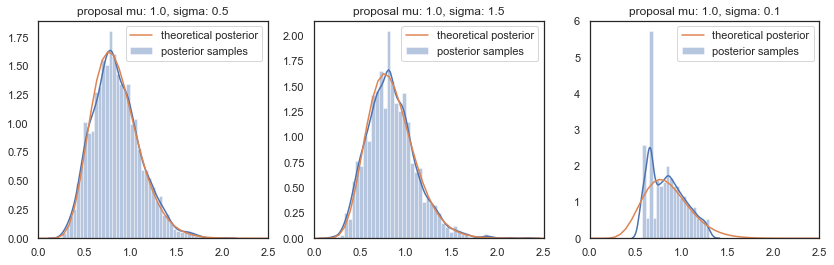

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
independent_MH(1.0, 0.5, axes[0])
independent_MH(1.0, 1.5, axes[1])
independent_MH(1.0, 0.1, axes[2])
plt.savefig("independent_MH.png")

In [127]:
# ランダムウォークMH法
def randomwalk_MH(scale_proposal=0.5, theta_init=4.0, n_sample=6000, burn=1000):
    theta_current = theta_init
    posterior = [theta_current]
    rejected = []
    count = 0 # count accepted proposals
    
    for i in tqdm_notebook(range(n_sample)):

        # 前のサンプルに基づき、次の候補が提案される
        theta_proposal = norm.rvs(loc=theta_current, scale=scale_proposal)

        # Lieklihood x prior
        p_current = posterior_kernel(theta_current)
        p_proposal = posterior_kernel(theta_proposal)

        # probability to accept proposal
        p_accept = p_proposal / p_current

        if np.random.rand() < p_accept:
            count += 1
            theta_current = theta_proposal
        else:
            rejected.append((i, theta_proposal))

        posterior.append(theta_current)
        
    print("accept ratio: {:.2%}".format(count / n_sample))
    return np.array(posterior), np.array(rejected)
    
#     plt.figure()
#     g = sns.distplot(posterior[burn:], ax=ax, label="posterior samples")
#     g.plot(x, gamma.pdf(x, a=11, scale=1./13), label="theoretical posterior")
#     g.legend()
#     g.set_title(f"proposal sigam: {scale_proposal}")
#     g.set_xlim(0, 2.5)
#     print("accept ratio: {:.2%}".format(count / n_sample))

In [151]:
def plot_posterior(posterior, burn=1000):
    g = sns.distplot(posterior[burn:], label="posterior samples")
    g.plot(x, gamma.pdf(x, a=11, scale=1./13), label="theoretical posterior")
    g.legend()
    g.set_xlim(0, 2.5)
    

def plot_trace(posterior, rejected):
    plt.plot(posterior, label="trace")
    plt.scatter(rejected[:, 0], rejected[:, 1], marker="o", color="r", s=4, label="rejected")
    plt.legend()

In [156]:
sigma1, sigma2, sigma3 = 0.5, 0.05, 2.0
posterior1, rejected1 = randomwalk_MH(sigma1)
posterior2, rejected2 = randomwalk_MH(sigma2)
posterior3, rejected3 = randomwalk_MH(sigma3)

accept ratio: 49.15%


accept ratio: 92.18%


accept ratio: 15.75%


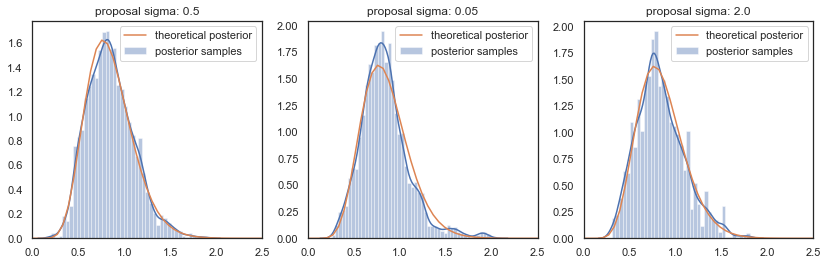

In [159]:
fig, axes = plt.subplots(figsize=(14, 4))
plt.subplot(131)
plot_posterior(posterior1)
plt.title(f"proposal sigma: {sigma1}")

plt.subplot(132)
plot_posterior(posterior2)
plt.title(f"proposal sigma: {sigma2}")

plt.subplot(133)
plot_posterior(posterior3)
plt.title(f"proposal sigma: {sigma3}")

plt.savefig("randomwalk_MH.png")

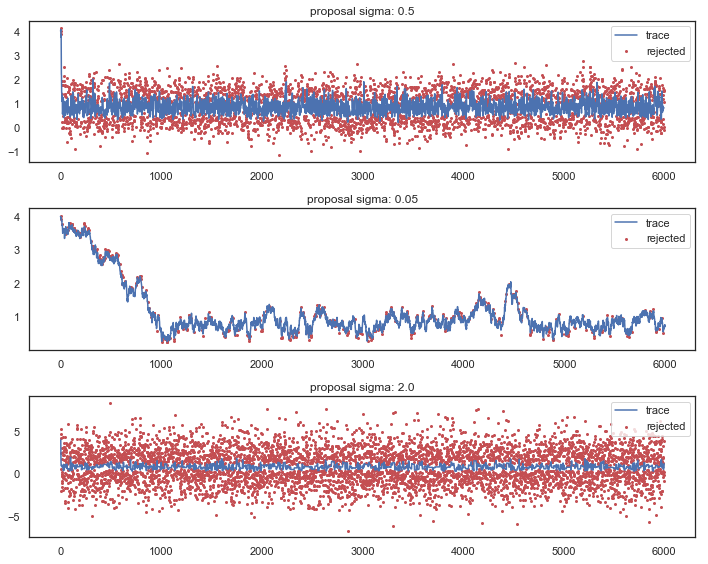

In [160]:
fig, axes = plt.subplots(figsize=(10, 8))
plt.subplot(311)
plot_trace(posterior1, rejected1)
plt.title(f"proposal sigma: {sigma1}")

plt.subplot(312)
plot_trace(posterior2, rejected2)
plt.title(f"proposal sigma: {sigma2}")

plt.subplot(313)
plot_trace(posterior3, rejected3)
plt.title(f"proposal sigma: {sigma3}")

plt.tight_layout()
plt.savefig("randomwalk_MH_trace.png")

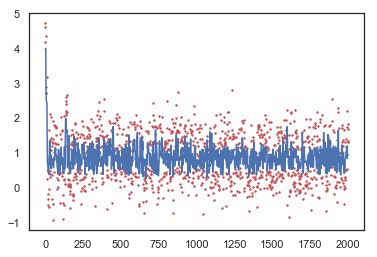

In [115]:
posterior, rejected = randomwalk_MH(0.5)
plt.plot(posterior)
plt.scatter(rejected[:, 0], rejected[:, 1], marker="o", color="r", s=2)

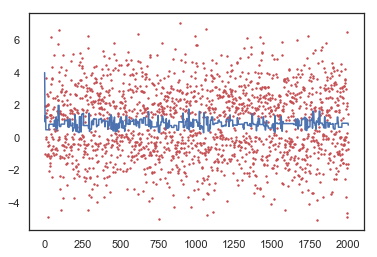

In [114]:
posterior, rejected = randomwalk_MH(2.0)
plt.plot(posterior)
plt.scatter(rejected[:, 0], rejected[:, 1], marker="o", color="r", s=2)

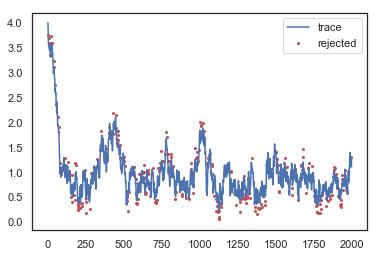

In [118]:
posterior, rejected = randomwalk_MH(0.1)
plt.plot(posterior, label="trace")
plt.scatter(rejected[:, 0], rejected[:, 1], marker="o", color="r", s=4, label="rejected")
plt.legend()

accept ratio: 47.75%


accept ratio: 87.15%


/Users/yuho.kida/python_DS/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


accept ratio: 16.30%


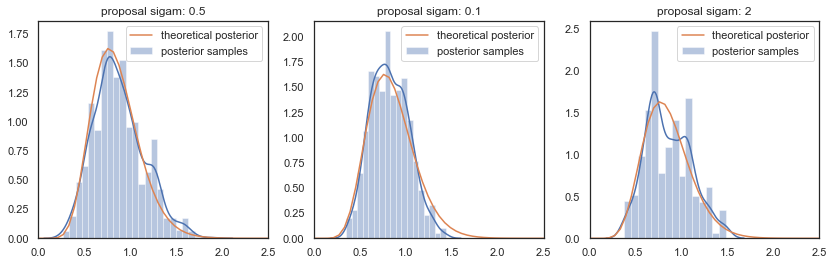

In [84]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
randomwalk_MH(axes[0], 0.5)
randomwalk_MH(axes[1], 0.1)
randomwalk_MH(axes[2], 2,0)
plt.savefig("randomwalk_MH.png")

accept ratio: 86.77%


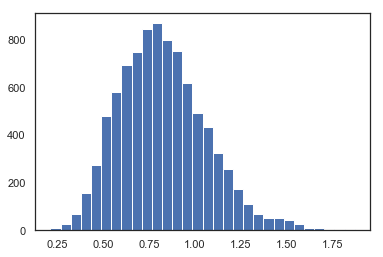

In [71]:
#ランダムウォークMH法
theta_init = 4.

theta_current = theta_init
samples = 10000
posterior = [theta_current]
count = 0

for i in tqdm_notebook(range(samples)):
    
    theta_proposal = norm.rvs(loc=theta_current, scale=0.1)
    # 正規分布だと負の値が提案されるので不適
#     theta_proposal = np.random.uniform(0.0, 3.0)

    # Lieklihood x prior
    p_current = posterior_kernel(theta_current)
    p_proposal = posterior_kernel(theta_proposal)
    
    # probability to accept proposal
    p_accept = p_proposal / p_current
    
    if np.random.rand() < p_accept:
        count += 1
        theta_current = theta_proposal
    
    posterior.append(theta_current)

fig = plt.hist(posterior[1000:], bins=30)
print("accept ratio: {:.2%}".format(count / samples))

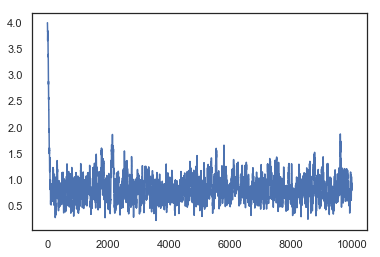

In [86]:
plt.plot(posterior)

HMC法

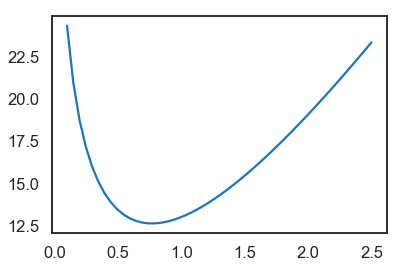

In [40]:
alpha = 11
lam = 13

eps = 0.01
L = 180
T = 1000

# h(theta) = np.log(prior * likelihood)
# h'(theta) = dh(theta) / d(theta)

def gamma_h(x, alpha, lam):
    return lam * x - (alpha - 1) * np.log(x)

def gamma_dh(x, alpha, lam):
    return lam - (alpha - 1) / x

xx = np.linspace(0.1, 2.5)
plt.plot(xx, gamma_h(xx, 11, 13))

標準正規分布に従うpを生成。これを運動量、現在のパラメータを平面位置、ポテンシャルエネルギーを対数尤度として、ハミルトニアンが一定の条件の元で一定時間移動させる。その後、再び運動量pをランダムに生成し、同じように移動させる。

In [143]:
p1 = 0
x1 = 0.1

x = x1
p = p1

res = [(x1, p1)]
for i in np.arange(L):
    # leap frog
    p_tmp = p - eps * gamma_dh(x, alpha, lam) / 2
    x_prop = x + eps * p_tmp
    p_prop = p_tmp - eps * gamma_dh(x_prop, alpha, lam) / 2

    def hamiltonian(x, p):
        return -x - p**2 / 2

    r = np.exp(hamiltonian(x, p) - hamiltonian(x_prop, p_prop))
#     print(r)
    if np.random.rand() < r:
        x = x_prop
        p = p_prop
        
    res.append((x, p))
        
# p = np.random.randn()
res = np.array(res)

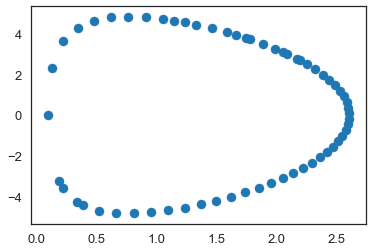

In [147]:
plt.scatter(res[:, 0][::3], res[:,1][::3])

In [103]:
alpha = 11
lam = 13

def gamma_h(x):
    global alpha, lam
    return lam * x - (alpha - 1) * np.log(x)

def gamma_dh(x):
    global alpha, lam
    return lam - (alpha - 1) / x

def hamiltonian(x, p):
    return gamma_h(x) +  p**2 / 2

def leap_frog(x, y, L, eps):
    """
    x: parameter
    y: p
    """
    res = [[x, y, hamiltonian(x, y)]]
    for _ in range(L):
        y -= eps * gamma_dh(x) / 2
        x  +=  eps * y
        y -= eps * gamma_dh(x) / 2
        res.append([x, y, hamiltonian(x, y)])
    return res

vhamiltonian = np.vectorize(hamiltonian) 

In [107]:
eps = 0.05
L = 15
T = 10

p1 = 0
theta1 = 0.1

theta = theta1
p = p1

for _  in range(2):
#     p = np.random.randn()
    res = leap_frog(theta, p, L, eps)

res = np.array(res)

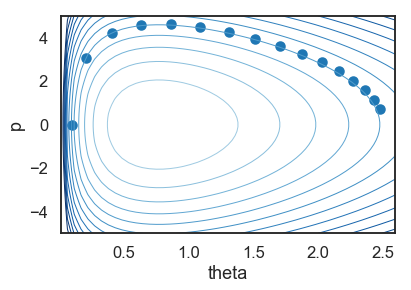

In [110]:
xx = np.linspace(0.01, 2.6)
yy = np.linspace(-5,5)
X, Y = np.meshgrid(xx, yy)
Z = vhamiltonian(X, Y)
plt.contour(X, Y, Z, linewidths=1, cmap=cm.Blues, levels=np.linspace(0,40,20))
plt.xlabel("theta")
plt.ylabel("p")

plt.scatter(res[:, 0], res[:, 1])

* 横軸：theta, 縦軸：h(theta)のプロット
* 横軸：theta, 縦軸：pのプロット

In [142]:
def leap_frog_step(x, y, L, eps):
    """
    x: parameter
    y: p
    """
    for _ in range(L):
        y -= eps * gamma_dh(x) / 2
        x  +=  eps * y
        y -= eps * gamma_dh(x) / 2
    return x, y

In [168]:
eps = 0.01
L = 100
T = 10

p1 = 0
theta1 = 0.1

theta = theta1
p = p1

res = []
for _  in range(T):
    accepted = False
    p = np.random.randn()
    theta_prop, p_prop = leap_frog_step(theta, p, L, eps)
    r = np.exp(hamiltonian(theta, p) - hamiltonian(theta_prop, p_prop))
#     print(r)
    if np.random.rand() < r:
        accepted = True
        theta= theta_prop
        p = p_prop
    res.append([theta_prop, p_prop, accepted])

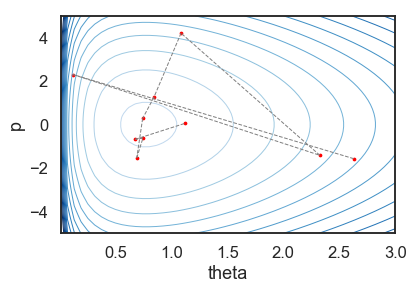

In [169]:
res = np.array(res)

xx = np.linspace(0.01, 3.)
yy = np.linspace(-5, 5)
X, Y = np.meshgrid(xx, yy)
Z = vhamiltonian(X, Y)
plt.contour(X, Y, Z, linewidths=1, cmap=cm.Blues, levels=np.linspace(0,50,20))
plt.xlabel("theta")
plt.ylabel("p")

plt.scatter(res[:, 0], res[:, 1], s=5, c="r")
for i in range(len(res) - 1):
    plt.plot(res[i: i+2, 0], res[i: i+2, 1], linestyle="--", linewidth=1, c="gray")

(array([ 71., 326., 343., 174.,  69.,  11.,   5.,   0.,   0.,   1.]),
 array([0.28818193, 0.51923905, 0.75029617, 0.98135329, 1.21241042,
        1.44346754, 1.67452466, 1.90558178, 2.1366389 , 2.36769603,
        2.59875315]),
 <a list of 10 Patch objects>)

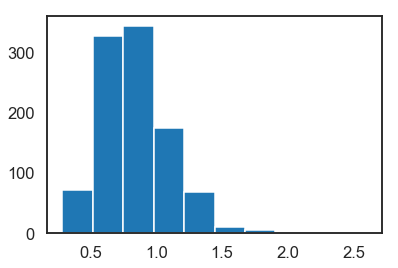

In [151]:
plt.hist(res[:, 0])

/Users/yuho.kida/python_DS/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


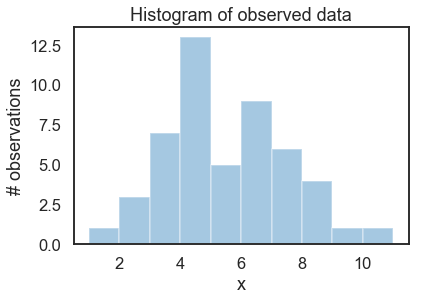

In [10]:
data = np.random.poisson(lam=5, size=50)
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

分散既知の正規分布が尤度の時、正規分布は共役事前分布なので、事後分布を正確に計算できる。

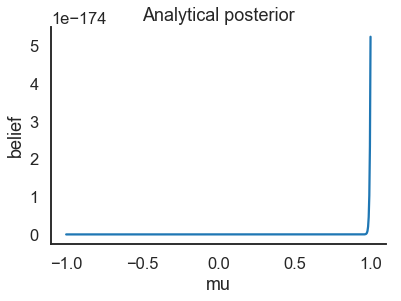

In [11]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

パラメータの初期値をランダムに決定する。メトロポリス法では、提案分布に基づき、パラメータの次の移動先をランダムに決める。現在のパラメータをmu, 適当な値をsigmaとした正規分布とする。  
移動先のパラメータの方が良いかどうかは、提案されたパラメータによる尤度からデータの確率（ベイズの定理の分子）を計算して決定する。
移動先の方が好ましい場合は必ず移動し、好ましくない場合は受容確率に基づいて移動する。

In [4]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return np.array(posterior)

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()


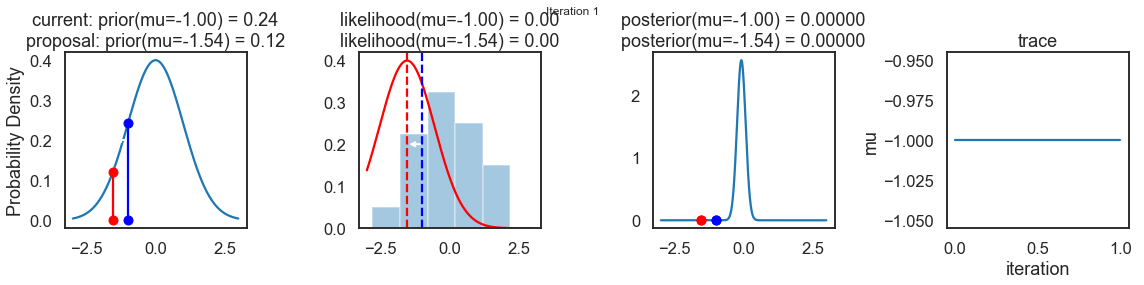

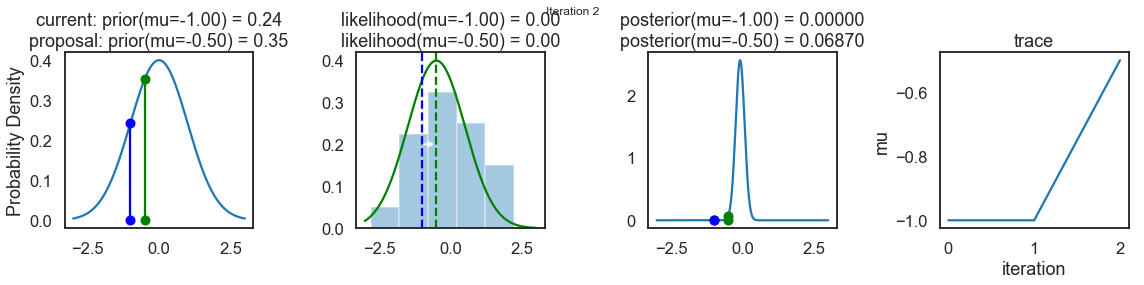

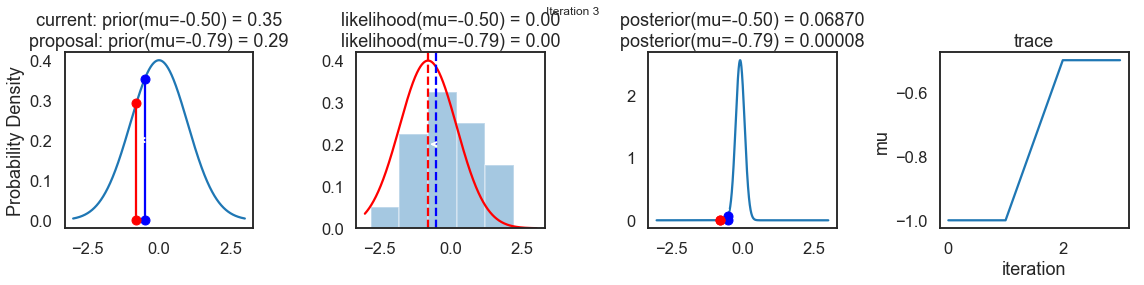

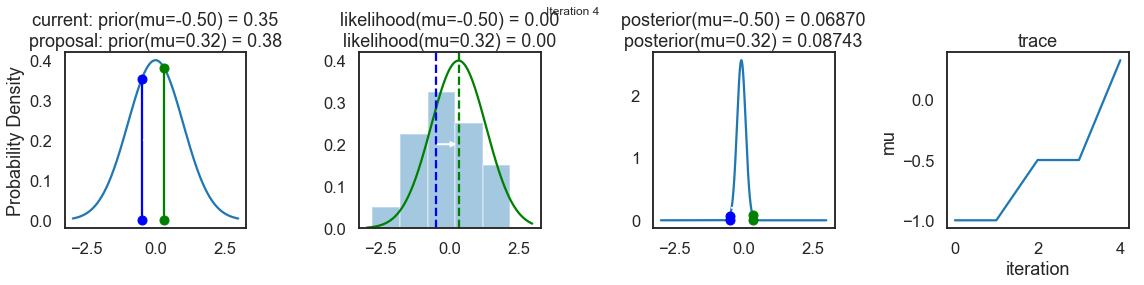

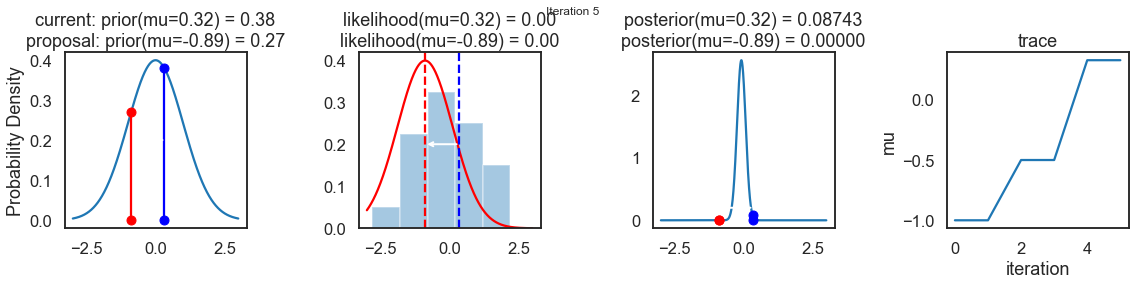

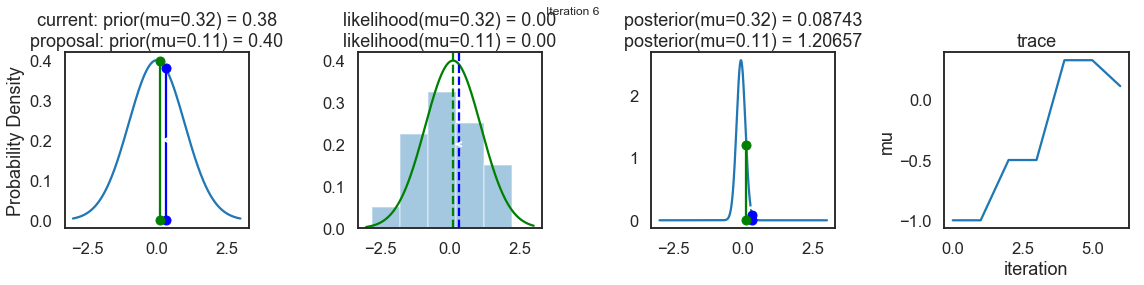

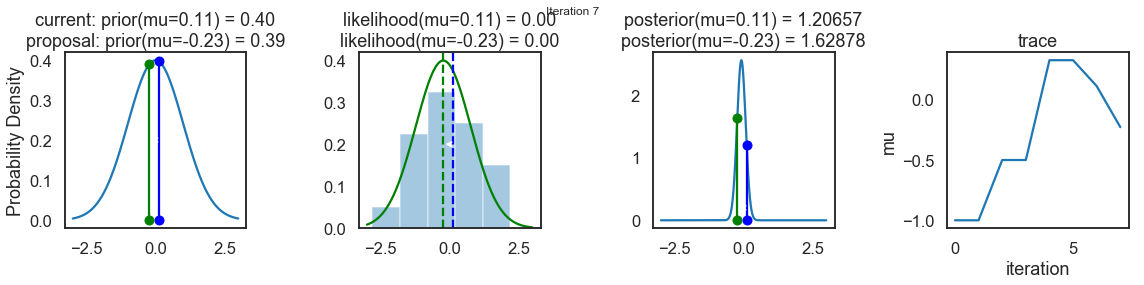

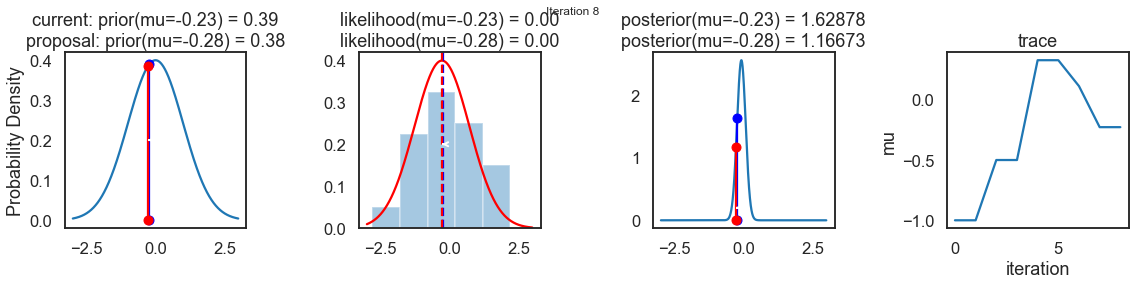

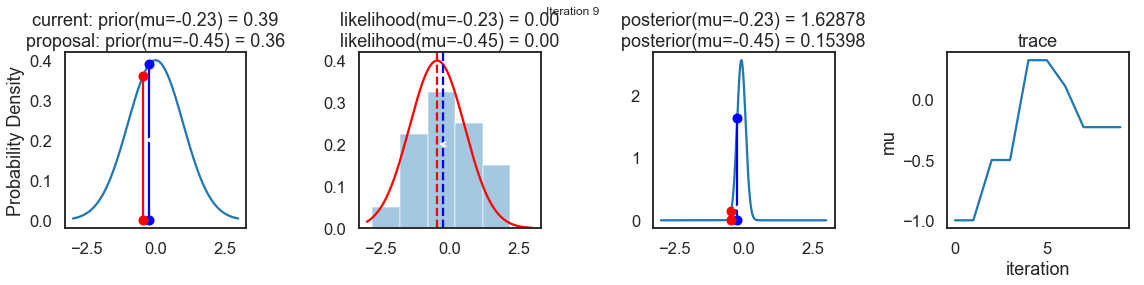

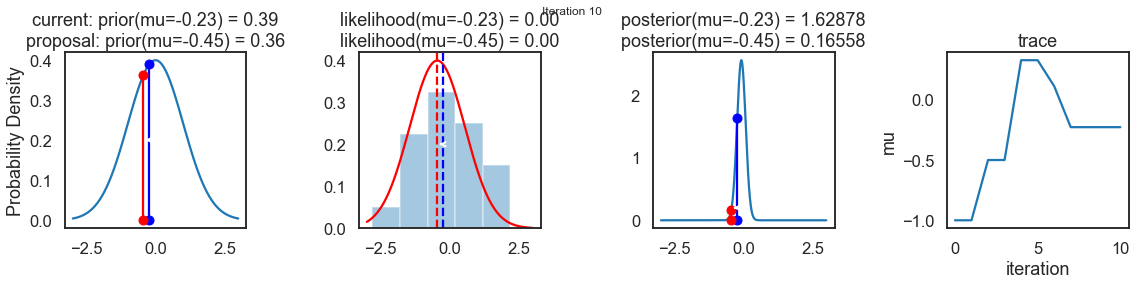

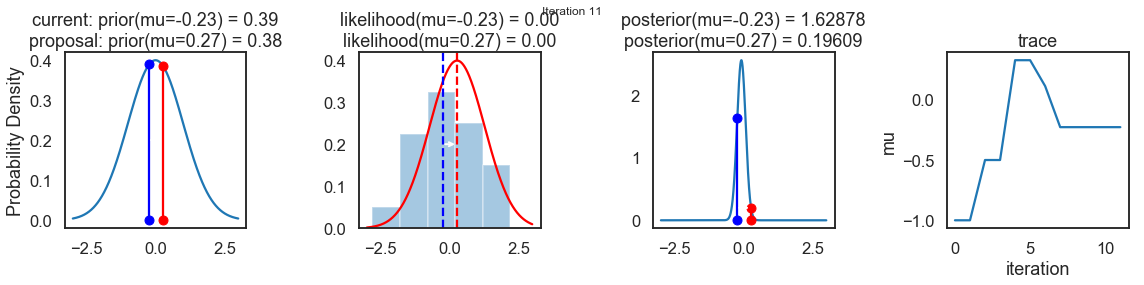

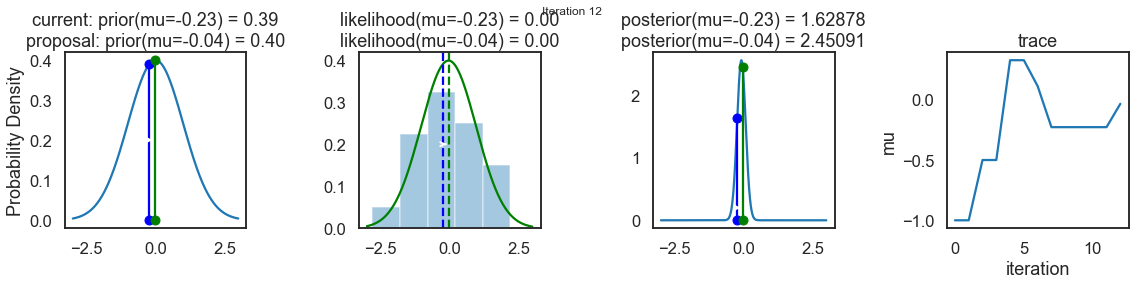

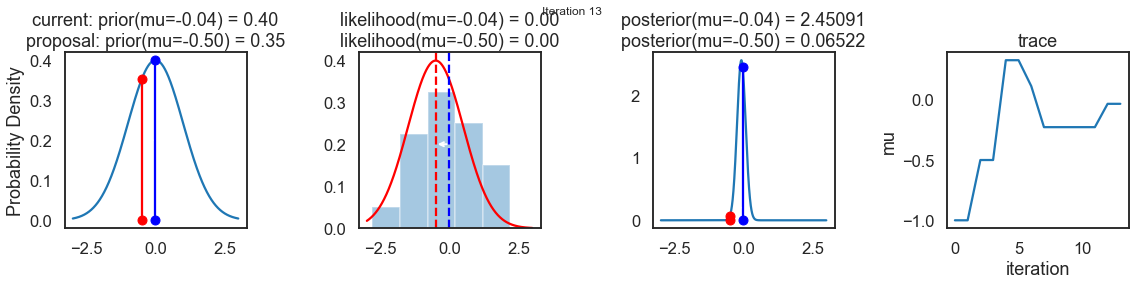

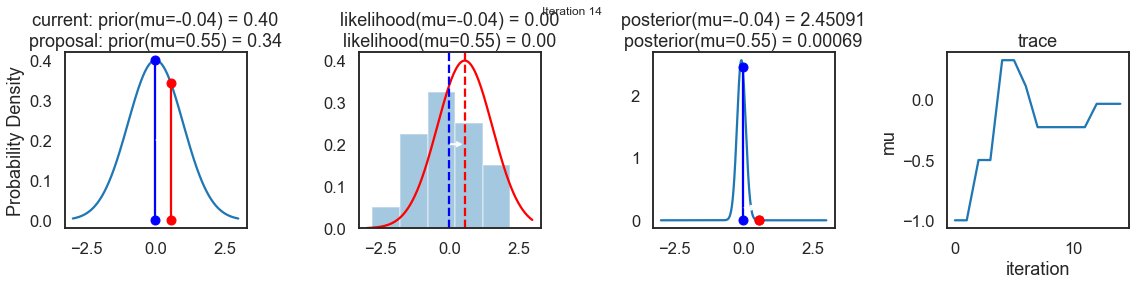

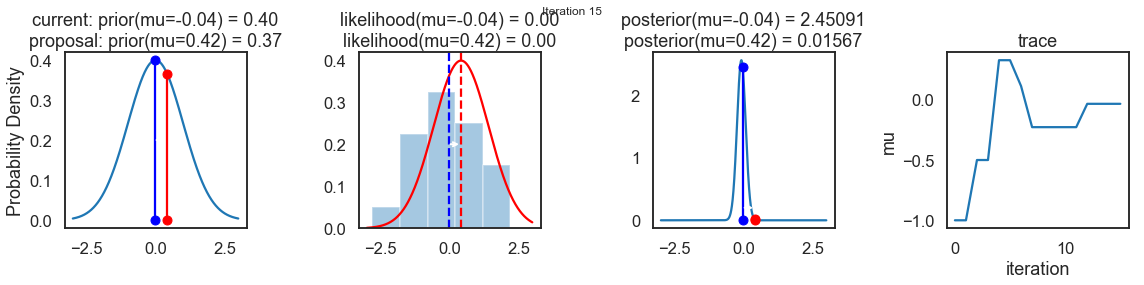

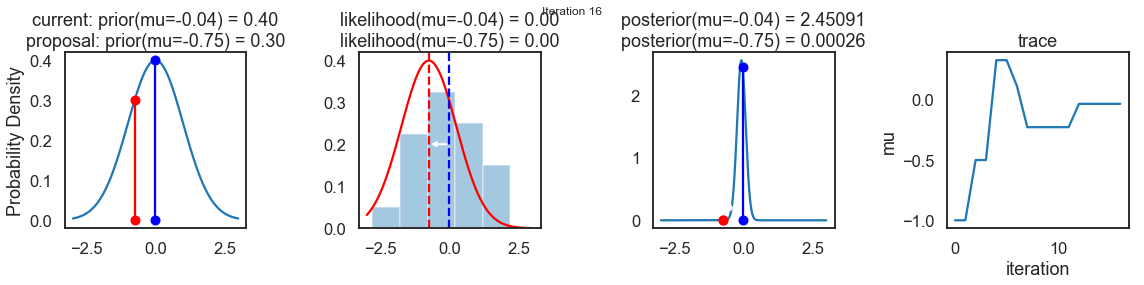

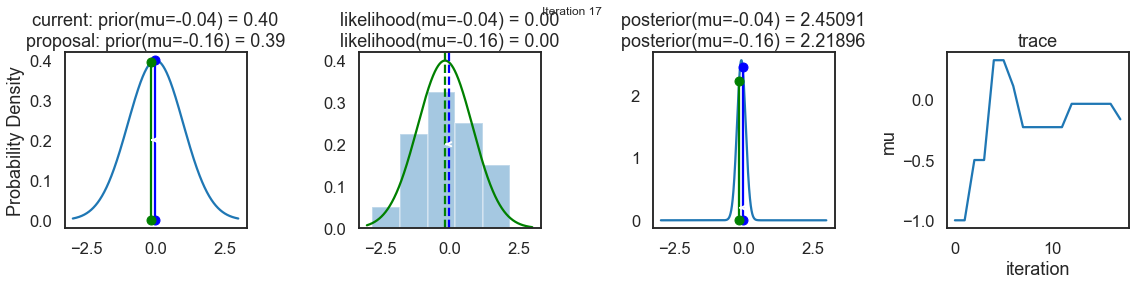

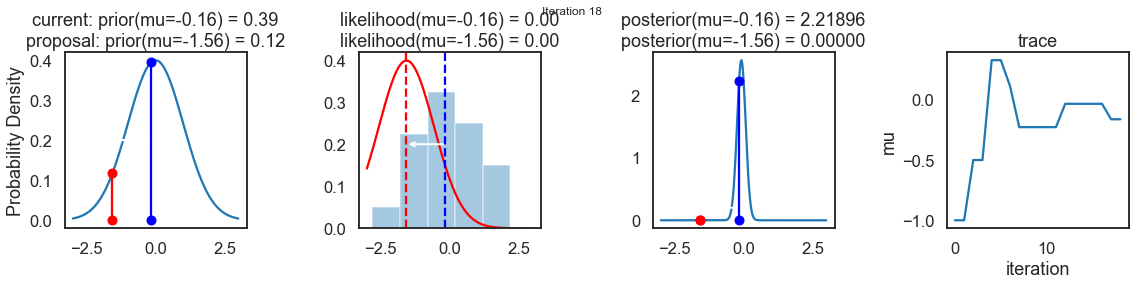

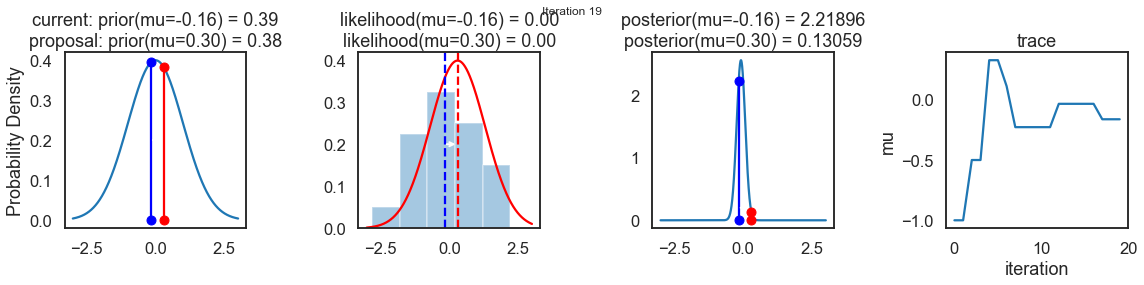

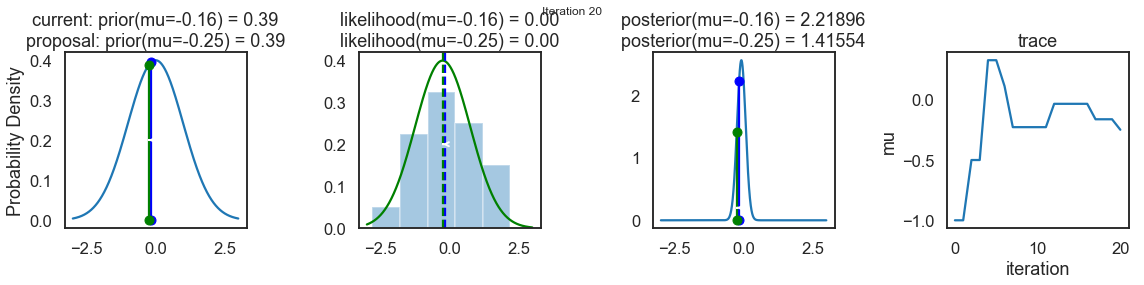

In [5]:
np.random.seed(123)
sampler(data, samples=20, mu_init=-1., plot=True);

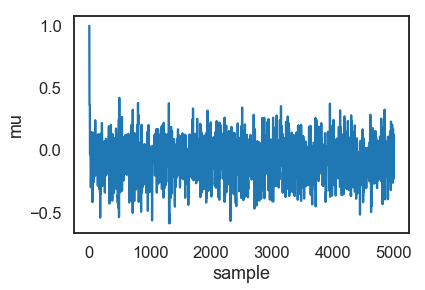

In [6]:
posterior = sampler(data, samples=5000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

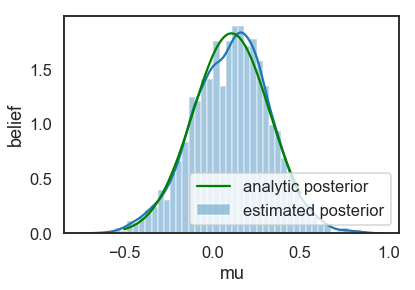

In [10]:
ax = plt.subplot()

sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();

提案分布の　sigmaは０.5としていた。小さすぎるとパラメータ空間の探索に時間がかかり、非効率的になる。一方で、大きすぎても受容率が低くなりすぎてしまう。

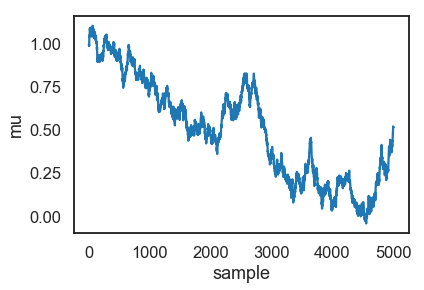

In [11]:
posterior_small = sampler(data, samples=5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots()
ax.plot(posterior_small);
_ = ax.set(xlabel='sample', ylabel='mu');

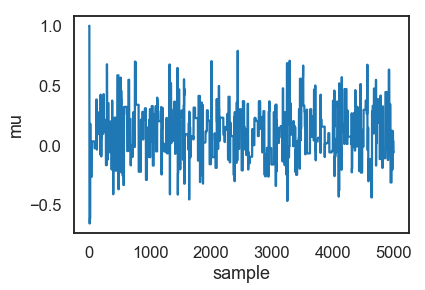

In [12]:
posterior_large = sampler(data, samples=5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots()
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu');
_ = ax.set(xlabel='sample', ylabel='mu');

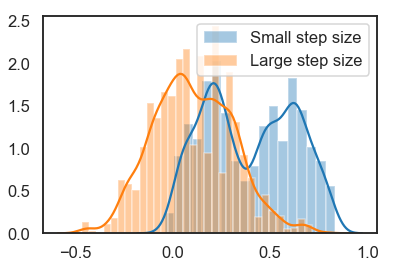

In [13]:
sns.distplot(posterior_small[1000:], label='Small step size')
sns.distplot(posterior_large[1000:], label='Large step size');
_ = plt.legend();

各サンプルが独立になっていてほしいが、ここではそうなっていない。自己相関を確認することで、効率よくサンプリングできているかを確認できる。
受容率が５０％程度になるように、提案分布の幅を調整し続ける方法がある。

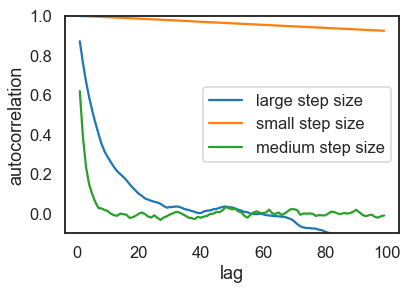

In [14]:
from pymc3.stats import autocorr
lags = np.arange(1, 100)
fig, ax = plt.subplots()
ax.plot(lags, [autocorr(posterior_large, l) for l in lags], label='large step size')
ax.plot(lags, [autocorr(posterior_small, l) for l in lags], label='small step size')
ax.plot(lags, [autocorr(posterior, l) for l in lags], label='medium step size')
ax.legend(loc=0)
_ = ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1))

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]
Sampling 4 chains: 100%|██████████| 62000/62000 [00:06<00:00, 9541.31draws/s] 
The number of effective samples is smaller than 25% for some parameters.
/Users/yuho.kida/python_DS/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


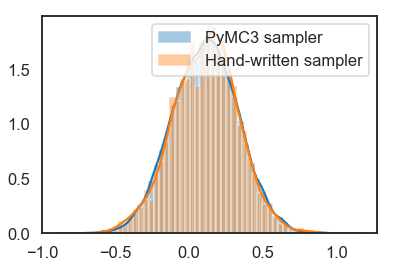

In [15]:
import pymc3 as pm

with pm.Model():
    mu = pm.Normal('mu', 0, 1)
    sigma = 1.
    returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data)
    
    step = pm.Metropolis()
    trace = pm.sample(15000, step)
    
sns.distplot(trace[2000:]['mu'], label='PyMC3 sampler');
sns.distplot(posterior[500:], label='Hand-written sampler');
plt.legend();

標準偏差も推定する場合、他の確率分布をモデルに使う場合も検討する。